In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Data preparing
df = pd.read_csv('./traces_seq.csv')
window_size = None
with open('./window_size.txt', 'r') as f:
    window_size = int(f.read())

classes = []
classes_len = 0
with open('../data/classes.txt', 'r') as f:
    classes = f.read().splitlines()
    classes_len = len(classes)

class_mapping = {
    key: classes[key] for key in range(len(classes))
}
print('window size: ', window_size)
print('classes len: ', classes_len)
print(class_mapping)

window size:  20
classes len:  5
{0: 'left', 1: 'noise', 2: 'one', 3: 'right', 4: 'thumbup'}


In [3]:
def row_tranform(row):
    # row = X.iloc[0, :].to_numpy().reshape((window_size, 5))
    poses = row[:, :4]
    clses = row[:, 4].astype(np.int32)
    new_cls = []

    for cls in clses:
        new_cls.append(onehot_encode(cls, class_mapping))

    new_cls = np.array(new_cls).reshape((window_size, classes_len))

    return np.concatenate([poses, new_cls], axis=1)

def onehot_encode(cls, mapping):
    res = np.zeros(len(mapping))
    res[cls] = 1

    return res


In [4]:
X = df.iloc[:, :5*window_size]
y = df.iloc[:, 5*window_size]
X.shape

(259, 100)

In [5]:

X_train = []
for i in range(len(X)):
    row = X.iloc[i, :].to_numpy().reshape(window_size, 5)
    X_train.append(row_tranform(row))

X_train = np.array(X_train).reshape((window_size*X.shape[0], 4 + classes_len))
X_train.shape

(5180, 9)

In [6]:
# rescale to 0-1
X_train[:, [0, 2]] = X_train[:, [0, 2]] / 1080
X_train[:, [1, 3]] = X_train[:, [1, 3]] / 720

In [7]:
X_train[:4, :]

array([[0.41405874, 0.51072396, 0.7057984 , 0.84673843, 0.        ,
        0.        , 0.        , 1.        , 0.        ],
       [0.41901779, 0.45702328, 0.7142373 , 0.82741648, 0.        ,
        0.        , 0.        , 1.        , 0.        ],
       [0.43445234, 0.40828213, 0.73386926, 0.78479529, 0.        ,
        0.        , 0.        , 1.        , 0.        ],
       [0.44856358, 0.35276688, 0.72332752, 0.75229645, 0.        ,
        0.        , 0.        , 1.        , 0.        ]])

In [8]:
class PoseDetectNN(nn.Module):
    def __init__(self, num_classes, pos_dimension, window_size, batch_size, bidirection=False,hidden_dim=10, rnn_hidden=10, rnn_layers=2) -> None:
        super(PoseDetectNN, self).__init__()

        self.batch_size = batch_size
        self.rnn_layers = rnn_layers
        self.rnn_hidden = rnn_hidden
        self.num_classes = num_classes
        self.pos_dimension = pos_dimension
        self.window_size = window_size
        self.bidirection = bidirection

        self.linear = nn.Linear(num_classes + pos_dimension, out_features=hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, rnn_hidden, rnn_layers, bidirectional=bidirection, batch_first=True)
        self.linear2 = nn.Linear((1+bidirection)*rnn_hidden, 1)
        self.linear3 = nn.Linear(window_size, 1)
    
    def forward(self, x):
        hidden = self.linear(x)

        h0, c0 = self.init_hidden(self.batch_size, self.rnn_layers, self.rnn_hidden, self.bidirection)

        out, (hn, cn) = self.rnn(hidden, (h0, c0))

        out = self.linear2(out[:, window_size-1, :]).reshape((self.batch_size))
        out = torch.sigmoid(out).view(-1)
        # out = self.linear3(out)
        # out = torch.sigmoid(out).view(-1)

        return out
    
    def init_hidden(self, batch_size, rnn_layers, rnn_hidden, bidirection=False, device=torch.device("cuda")):
        h0 = torch.randn((1+bidirection)*rnn_layers, batch_size, rnn_hidden, device=device)
        c0 = torch.randn((1+bidirection)*rnn_layers, batch_size, rnn_hidden, device=device)
        return h0, c0
        

In [9]:
model = PoseDetectNN(classes_len, 4, window_size, 1)
model.cuda()

PoseDetectNN(
  (linear): Linear(in_features=9, out_features=10, bias=True)
  (rnn): LSTM(10, 10, num_layers=2, batch_first=True)
  (linear2): Linear(in_features=10, out_features=1, bias=True)
  (linear3): Linear(in_features=20, out_features=1, bias=True)
)

In [10]:
t = torch.Tensor(X_train[0:window_size, :]).reshape((1, window_size, 9)).to(torch.device('cuda'))
output = model(t)
label = torch.Tensor([y[0]]).to(torch.device('cuda'))

In [11]:
output = model(t)
label = torch.Tensor([y[0]]).to(torch.device('cuda'))

criterion = nn.BCELoss()
loss = criterion(output, label)
loss

tensor(0.6226, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)

In [12]:
# train
n_epochs = 1000
lr = 0.01
device = torch.device('cuda')

# criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [13]:
losses = []
for epoch in range(1, n_epochs+1):
    optimizer.zero_grad()
    total_loss = 0
    
    for i in range(0, len(X_train), window_size):
        _input = torch.Tensor(X_train[i:i+window_size, :].reshape(1, window_size, 4+classes_len)).to(device)
        label = torch.Tensor([y[int(i/window_size)]]).to(device)
        output = model(_input).to(device)

        loss = criterion(output, label)
        loss.backward()

        total_loss += loss.item()

    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(total_loss))

    optimizer.step()
    losses.append(total_loss)


Epoch: 10/1000............. Loss: 172.7880
Epoch: 20/1000............. Loss: 150.4258
Epoch: 30/1000............. Loss: 121.4452
Epoch: 40/1000............. Loss: 119.3604
Epoch: 50/1000............. Loss: 118.6009
Epoch: 60/1000............. Loss: 106.3870
Epoch: 70/1000............. Loss: 89.7538
Epoch: 80/1000............. Loss: 83.4447
Epoch: 90/1000............. Loss: 87.4194
Epoch: 100/1000............. Loss: 253.6317
Epoch: 110/1000............. Loss: 171.3508
Epoch: 120/1000............. Loss: 167.8633
Epoch: 130/1000............. Loss: 168.5419
Epoch: 140/1000............. Loss: 168.0562
Epoch: 150/1000............. Loss: 167.2342
Epoch: 160/1000............. Loss: 166.4414
Epoch: 170/1000............. Loss: 165.0827
Epoch: 180/1000............. Loss: 159.9773
Epoch: 190/1000............. Loss: 139.2410
Epoch: 200/1000............. Loss: 123.6182
Epoch: 210/1000............. Loss: 100.0793
Epoch: 220/1000............. Loss: 133.9917
Epoch: 230/1000............. Loss: 134.6520


In [14]:
print(len(y))

259


In [15]:
X_train.shape

(5180, 9)

In [16]:
X_train.shape[0] / 5

1036.0

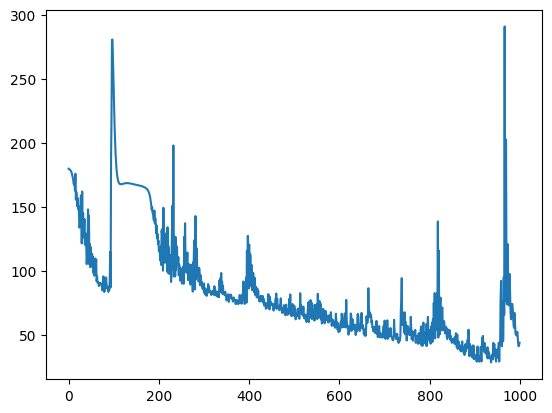

In [17]:
plt.plot(losses)

In [ ]:
torch.save(model.state_dict(), 'pdnn.pt')